In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from Model_MFML import ModelMFML as MFML
from sklearn.utils import shuffle
import qml.kernels as k
from qml.math import cho_solve
import seaborn as sns
import matplotlib.pylab as pyl
import matplotlib.ticker as mticker
from sklearn import preprocessing

In this notebook a special case of using MFML is studied. 1,500 samples are chosen randomly from each of the 9 molecules resulting in a total of 13,500 samples. Of these, 11,000 are used a training set, 500 as a validation set (for o-MFML), and 2,000 as a test set.

With this set-up the multifidelity dataset can be seen as a total of $9\times 15000=135,000$ samples. 

In [2]:
def prep_data():
    molnames = ['urea','acrolein','alanine','sma','nitrophenol','urocanic','dmabn','thymine','o-hbdi']
    idx = np.arange(0,15000)
    idx = shuffle(idx,random_state=42)
    idx=idx[:1500]
    
    X=np.zeros((13500,6438),dtype=float) #largest SLATM is for o-hbdi with 6438 features. Rest will be padded to this size.
    y_all = np.zeros((13500,5),dtype=float)
    
    start=0
    end=1500
    idx_names = np.zeros((13500),dtype=float)
    
    for i,m in tqdm(enumerate(molnames),desc='building composite dataset of uncentered SCF'):
        names = np.full(1500,i)
        idx_names[start:end] = np.copy(names)
        #temp_X = np.load(f'Reps/{m}_SLATM.npy')
        #X[start:end,:temp_X.shape[-1]] = temp_X[idx,:]
        temp_data=np.load(f'../dataset/QeMFi_{m}.npz')['SCF']
        y_all[start:end,:] = temp_data[idx,:]
        
        #increment for next molecule
        start+= 1500
        end += 1500
    y_new = np.zeros((5),dtype=object)
    
    X,idx_names = shuffle(X,idx_names,random_state=42)
    y_train = np.zeros((5),dtype=object)
    for i in range(5):
        y_all[:,i] = shuffle(y_all[:,i],random_state=42)
        y_new[i] = y_all[:,i]
        y_train[i] = y_new[i][:11000]
    
    X_train = X[:11000,:]
    #y_train = y_new[:11000,:]
    X_val = X[11000:11500,:]
    y_val = y_new[-1][11000:11500]
    X_test = X[11500:,:]
    y_test = y_new[-1][11500:]
    
    y_train = y_train[::-1]
    return X_train, X_val, X_test, y_train, y_val, y_test, idx_names
    

building composite dataset of uncentered SCF: 0it [00:00, ?it/s]

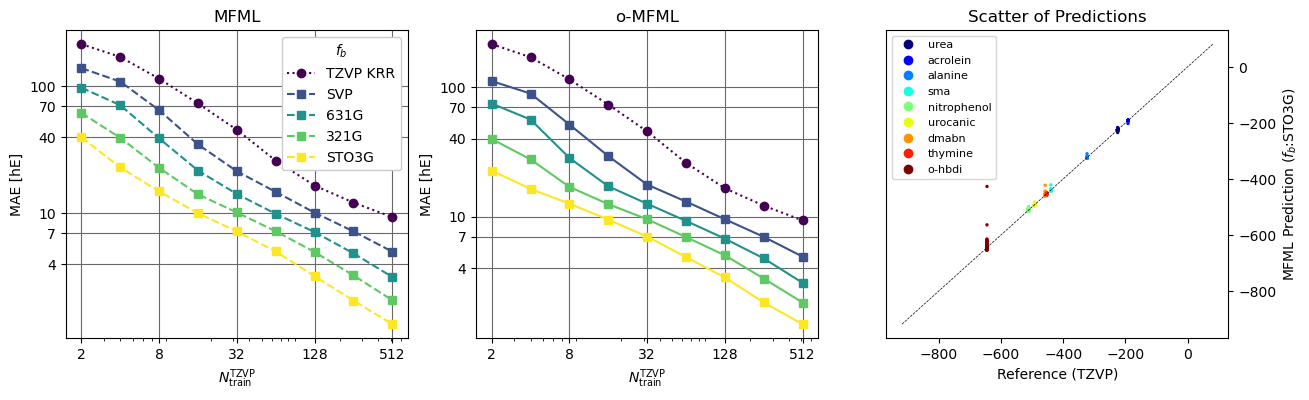

In [3]:
def plotting_routine():
    
    _,_,_, _, y_val, y_test, mol_IDs = prep_data()
    
    sf_preds = np.load('outputs/specialcase/sf_preds.npy')
    sf_mae = np.load('outputs/specialcase/sf_mae.npy')
    def_preds = np.load('outputs/specialcase/def_preds.npy',allow_pickle=True)
    def_mae = np.load('outputs/specialcase/def_mae.npy',allow_pickle=True)
    ols_preds = np.load('outputs/specialcase/ols_preds.npy',allow_pickle=True)
    ols_mae = np.load('outputs/specialcase/ols_mae.npy',allow_pickle=True)
    
    fig,ax = plt.subplots(1,3,figsize=(15,4))
    
    ax[2].set_title('Scatter of Predictions')
    scatter1=ax[2].scatter(y_test,def_preds[0],s=2,c=mol_IDs[-2000:],cmap='jet')
    #scatter2=ax[2].scatter(y_test,y_test,s=5,c=np.full(2000,9),cmap='gray')
    handles=scatter1.legend_elements()[0]
    #handles.append(scatter2.legend_elements()[0][0])
    ax[2].legend(handles=handles,
               labels=['urea','acrolein','alanine','sma','nitrophenol','urocanic','dmabn','thymine','o-hbdi','reference (TZVP)'],ncols=1, fontsize=8)
    ax[2].set_xlabel('Reference (TZVP)')
    ax[2].set_ylabel('MFML Prediction ($f_b$:STO3G)')
    ax[2].plot([np.min(y_test)-2*np.std(y_test),2*np.std(y_test)+np.max(y_test)],
             [np.min(y_test)-2*np.std(y_test),np.max(y_test)+2*np.std(y_test)],linestyle='--',color='k',linewidth=0.5)
    ax[2].yaxis.set_label_position("right")
    ax[2].yaxis.tick_right()
    markers = ['^','*','P','d']
    colors = pyl.cm.viridis(np.linspace(0,1,5))
    n = 2**np.arange(1,10)
    fids = ['STO3G','321G','631G','SVP','TZVP']
    
    ax[0].set_title('MFML')
    ax[1].set_title('o-MFML')
    ax[0].loglog(n,sf_mae,marker='o',label='TZVP KRR',linestyle=':',color=colors[0])
    ax[1].loglog(n,sf_mae,marker='o',label='TZVP KRR',linestyle=':',color=colors[0])
    for i in range(3,-1,-1):
        ax[0].loglog(n,def_mae[i],marker='s',label=fids[i],linestyle='--',color=colors[4-i])
        ax[1].loglog(n,ols_mae[i],marker='s',label=fids[i],color=colors[4-i])
    ax[0].legend(title='$f_b$',frameon=1.0, framealpha=1.0)
    y_minor = mticker.LogLocator(base = 10, subs = np.arange(1.0,10,3), numticks = 20)
    y_major = mticker.LogLocator(base = 10, subs = np.arange(1.0,10,3), numticks = 10)
    
    for i in range(2):
        ax[i].xaxis.set_major_formatter(mticker.ScalarFormatter())
        ax[i].set_xticks([2,8,32,128,512])
        ax[i].yaxis.set_minor_formatter(mticker.ScalarFormatter())
        ax[i].yaxis.set_major_formatter(mticker.ScalarFormatter())
        ax[i].yaxis.set_minor_locator(y_minor)
        ax[i].yaxis.set_major_locator(y_major)
        ax[i].grid(True, which="major", ls="-",color='dimgray')
        ax[i].grid(True, axis='y', which="minor", ls="--",color='lightgray')
        ax[i].yaxis.set_tick_params(labelleft=True,which='both')
        ax[i].set_xlabel('$N_{\mathrm{train}}^{\mathrm{TZVP}}$')
        ax[i].set_ylabel('MAE [hE]')
    
plotting_routine()
plt.savefig('ExtendedDataset_all.pdf',bbox_inches='tight',format='pdf')

# Time vs MAE 

In [4]:
def MFML_times_special(mol_IDs):
    mol_IDs = mol_IDs[:11000]
    all_times = np.zeros((9,5),dtype=float)
    molnames = ['urea','acrolein','alanine','sma',
                'nitrophenol','urocanic',
                'dmabn','thymine','o-hbdi']
    for i in range(9):
        all_times[i,:] = np.load(f'../dataset/QeMFi_{molnames[i]}.npz',
                                 allow_pickle=True)['t']
    inds = np.load('outputs/specialcase/index_index.npy',allow_pickle=True)[0][0][:,0]
    train_IDs = np.asarray(mol_IDs[inds],dtype=int)
    train_times = all_times[train_IDs,:]
    
    MFML_times = np.zeros((5,9),dtype=float)
    temp_times = np.zeros((9),dtype=float)
    
    for f in range(5):
        for n in range(1,10):
            temp_times[n-1] += np.sum(train_times[:2**(n+f),4-f])
        MFML_times[f,:] = np.copy(temp_times)
    
    return MFML_times/60.0

In [5]:
molnames = ['urea','acrolein','alanine','sma',
            'nitrophenol','urocanic',
            'dmabn','thymine','o-hbdi']
all_times = np.zeros((9,5),dtype=float)
for i in range(9):
    all_times[i,:] = np.load(f'../dataset/QeMFi_{molnames[i]}.npz',
                             allow_pickle=True)['t']


In [6]:
np.max(all_times)/np.min(all_times)

107.45874773663631

building composite dataset of uncentered SCF: 0it [00:00, ?it/s]

6.385322748154371


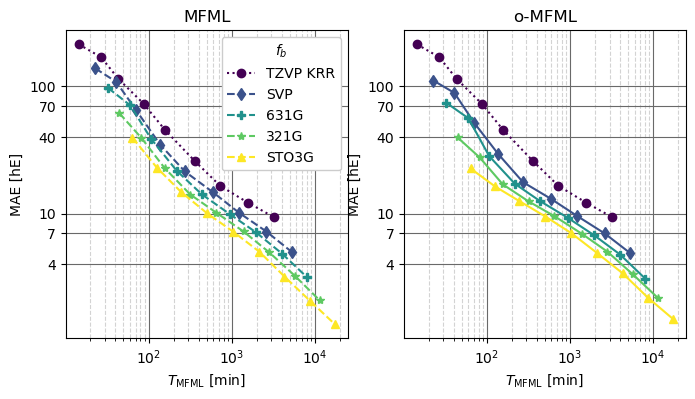

In [7]:
def time_mae():
    sf_mae = np.load('outputs/specialcase/sf_mae.npy')
    def_mae = np.load('outputs/specialcase/def_mae.npy',allow_pickle=True)
    ols_mae = np.load('outputs/specialcase/ols_mae.npy',allow_pickle=True)
    
    fids = ['STO3G','321G','631G','SVP','TZVP']
    
    fig,ax = plt.subplots(1,2,figsize=(8,4),sharey=True)
    markers = ['^','*','P','d']
    colors = pyl.cm.viridis(np.linspace(0,1,5))
    n = 2**np.arange(1,10)
    fids = ['STO3G','321G','631G','SVP','TZVP']
    
    ax[0].set_title('MFML')
    ax[1].set_title('o-MFML')
    
    #return MFML times
    _,_,_, _, _, _, mol_IDs = prep_data()
    MFML_times = MFML_times_special(mol_IDs)
    
    #SF plots
    ax[0].loglog(MFML_times[0],sf_mae,marker='o',color=colors[0],label='TZVP KRR',linestyle=':')
    ax[1].loglog(MFML_times[0],sf_mae,marker='o',color=colors[0],label='TZVP KRR',linestyle=':')
    
    #MFML and o-MFML plots
    for i in range(3,-1,-1):
        ax[0].loglog(MFML_times[4-i],def_mae[i],marker=markers[i],color=colors[4-i],label=fids[i],linestyle='--')
        ax[1].loglog(MFML_times[4-i],ols_mae[i],marker=markers[i],color=colors[4-i],label=fids[i],linestyle='-')
    
    ax[0].legend(title='$f_b$',frameon=1.0, framealpha=1.0)
    y_minor = mticker.LogLocator(base = 10, subs = np.arange(1.0,10,3), numticks = 20)
    y_major = mticker.LogLocator(base = 10, subs = np.arange(1.0,10,3), numticks = 10)
    
    for i in range(2):
        ax[i].yaxis.set_minor_formatter(mticker.ScalarFormatter())
        ax[i].yaxis.set_major_formatter(mticker.ScalarFormatter())
        ax[i].yaxis.set_minor_locator(y_minor)
        ax[i].yaxis.set_major_locator(y_major)
        ax[i].grid(True, which="major", ls="-",color='dimgray')
        ax[i].grid(True, axis='both', which="minor", ls="--",color='lightgray')
        ax[i].yaxis.set_tick_params(labelleft=True,which='both')
        ax[i].set_xlabel('$T_{\mathrm{MFML}}$ [min]')
        ax[i].set_ylabel('MAE [hE]')
        
    #plt.savefig('ExtendedDataset_TimevsMAE.pdf',format='pdf',bbox_inches='tight',dpi=150)
    print(MFML_times[0][-1]/MFML_times[-1][3])
time_mae()